# nhật ký thực nghiệm 20-12-2025

thử nghiệm chia dữ liệu thành các nhóm dựa theo cách thức hình thành liên kết phân tử. Mục đích để phân tích loại liên kết phân tử ảnh hưởng thế nào đến nhiệt độ nóng chảy của hợp chất.

In [ ]:
import json
import subprocess
import sys

def ensure_package(import_name: str, install_name: str | None = None) -> None:
    """Install a pip package if missing (best-effort)."""
    install_name = install_name or import_name
    result = subprocess.run(
        [sys.executable, '-m', 'pip', 'list', '--format=json'],
        check=True,
        capture_output=True,
        text=True,
    )
    installed = {pkg['name'].lower() for pkg in json.loads(result.stdout)}
    # Some packages have different import vs distribution names (e.g., rdkit-pypi -> rdkit)
    if import_name.lower() in installed or (install_name and install_name.lower() in installed):
        print(f'{import_name} already installed.')
        return
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', install_name])
    print(f'Installed {install_name} (import as {import_name}).')

# Install baseline modeling deps if missing (best-effort)
for pkg in [
    ('scikit-learn', 'scikit-learn'),
    ('lightgbm', 'lightgbm'),
    ('numpy', 'numpy'),
    ('pandas', 'pandas'),
    ('rdkit', 'rdkit'),
    ('matplotlib', 'matplotlib'),
    ('seaborn', 'seaborn'),
]:
    try:
        ensure_package(pkg[0], pkg[1])
    except Exception as exc:
        print(f"Package install check failed for {pkg}: {exc}")


scikit-learn already installed.
lightgbm already installed.
numpy already installed.
pandas already installed.
rdkit already installed.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv('result/data/melting_point_features.csv') 

# note

Chia dữ liệu thành các nhóm:
- nhóm kim loại
- nhóm hidrocarbon
- nhóm halogen hidrocarbon
- nhóm hợp chất hữu cơ có chứa nguyên tố khác (O, N, S, P,...)
- nhóm hợp chất vô cơ

In [ ]:
# 1) Imports
from collections import Counter
import re
import pandas as pd
try:
    from rdkit import Chem
    RDKit_AVAILABLE = True
except Exception:
    RDKit_AVAILABLE = False

# 2) metal symbols (common metals + lanthanides/actinides can be extended)
METALS = {
    "Li","Be","Na","Mg","Al","K","Ca","Sc","Ti","V","Cr","Mn","Fe","Co","Ni","Cu","Zn",
    "Ga","Ge","Rb","Sr","Y","Zr","Nb","Mo","Tc","Ru","Rh","Pd","Ag","Cd","In","Sn",
    "Cs","Ba","La","Ce","Pr","Nd","Pm","Sm","Eu"," Gd","Tb","Dy","Ho","Er","Tm","Yb",
    "Lu","Hf","Ta","W","Re","Os","Ir","Pt","Au","Hg","Tl","Pb","Bi","Po","Fr","Ra",
    "Ac","Th","Pa","U","Np","Pu"
}
# clean METALS spacing issues:
METALS = {m.strip() for m in METALS}

# 3) helper to get element symbols from SMILES (RDKit preferred)
elem_re = re.compile(r'([A-Z][a-z]?)')
def elements_from_smiles_rdkit(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return set()
    return {atom.GetSymbol() for atom in mol.GetAtoms()}

def elements_from_smiles_regex(smiles):
    # remove isotopes like 12C and bracket contents' internal digits for simpler parsing
    s = re.sub(r'\[.*?\]', lambda m: re.sub(r'\d+','',m.group(0)), smiles)
    return set(elem_re.findall(s))

def get_elements(smiles):
    if RDKit_AVAILABLE:
        el = elements_from_smiles_rdkit(smiles)
        if el:
            return el
    return elements_from_smiles_regex(smiles)

# 4) classifier
def classify_smiles(smiles):
    if not isinstance(smiles, str) or smiles.strip()=="":
        return "unknown"
    s = smiles.strip()
    # quick ionic / explicit charge detection
    if '+' in s or '-' in s:
        # presence of charges in SMILES often indicates salts/ionic complexes
        # but we still look at elements for better label
        ionic = True
    else:
        ionic = False

    elements = {e for e in get_elements(s) if e != 'H'}
    if not elements:
        return "unknown"

    # metal-containing
    if any(el in METALS for el in elements):
        return "metal-containing (coordination/complex)"

    # contains carbon?
    if 'C' in elements:
        # hydrocarbons: only carbon (and implicit H)
        nonC = elements - {'C','H'}
        if not nonC:
            return "hydrocarbon"
        # if only halogens + C -> halogenated hydrocarbon
        halogens = {'F','Cl','Br','I'}
        if nonC.issubset(halogens):
            return "halogenated hydrocarbon"
        # if O,N,S,P etc present -> heteroatom-containing organic
        return "organic (heteroatom-containing)"
    else:
        # no carbon: inorganic (but could be small organometallic fragments)
        if ionic:
            return "inorganic ionic"
        return "inorganic (non-carbon)"

df = pd.read_csv("result/data/melting_point_features.csv")
df["chem_type"] = df["SMILES"].fillna("").astype(str).apply(classify_smiles)


print(df["chem_type"].value_counts(dropna=False))


[15:46:12] WARNING: not removing hydrogen atom without neighbors
[15:46:13] WARNING: not removing hydrogen atom without neighbors
[15:46:13] WARNING: not removing hydrogen atom without neighbors
[15:46:13] WARNING: not removing hydrogen atom without neighbors
[15:46:13] WARNING: not removing hydrogen atom without neighbors
[15:46:13] WARNING: not removing hydrogen atom without neighbors
[15:46:13] WARNING: not removing hydrogen atom without neighbors
[15:46:13] WARNING: not removing hydrogen atom without neighbors
[15:46:13] WARNING: not removing hydrogen atom without neighbors
[15:46:13] WARNING: not removing hydrogen atom without neighbors
[15:46:13] WARNING: not removing hydrogen atom without neighbors
[15:46:13] WARNING: not removing hydrogen atom without neighbors
[15:46:13] WARNING: not removing hydrogen atom without neighbors
[15:46:13] WARNING: not removing hydrogen atom without neighbors
[15:46:13] WARNING: not removing hydrogen atom without neighbors
[15:46:13] WARNING: not r

chem_type
organic (heteroatom-containing)            9246
metal-containing (coordination/complex)     623
hydrocarbon                                 269
halogenated hydrocarbon                     221
inorganic (non-carbon)                      113
inorganic ionic                              45
unknown                                       3
Name: count, dtype: int64


[15:46:13] WARNING: not removing hydrogen atom without neighbors
[15:46:13] WARNING: not removing hydrogen atom without neighbors
[15:46:13] WARNING: not removing hydrogen atom without neighbors
[15:46:13] WARNING: not removing hydrogen atom without neighbors
[15:46:13] WARNING: not removing hydrogen atom without neighbors
[15:46:13] WARNING: not removing hydrogen atom without neighbors
[15:46:13] WARNING: not removing hydrogen atom without neighbors
[15:46:13] WARNING: not removing hydrogen atom without neighbors
[15:46:13] WARNING: not removing hydrogen atom without neighbors
[15:46:13] WARNING: not removing hydrogen atom without neighbors


In [7]:
# save
df.to_csv("result/data/melting_point_features_with_type.csv", index=False)

# nhận xét

trong bảng phân bố:

- nhóm hợp chất hữu cơ có chứa nguyên tố khác chiếm đa số

- có một số dữ liệu không xác định -> sẽ loại bỏ



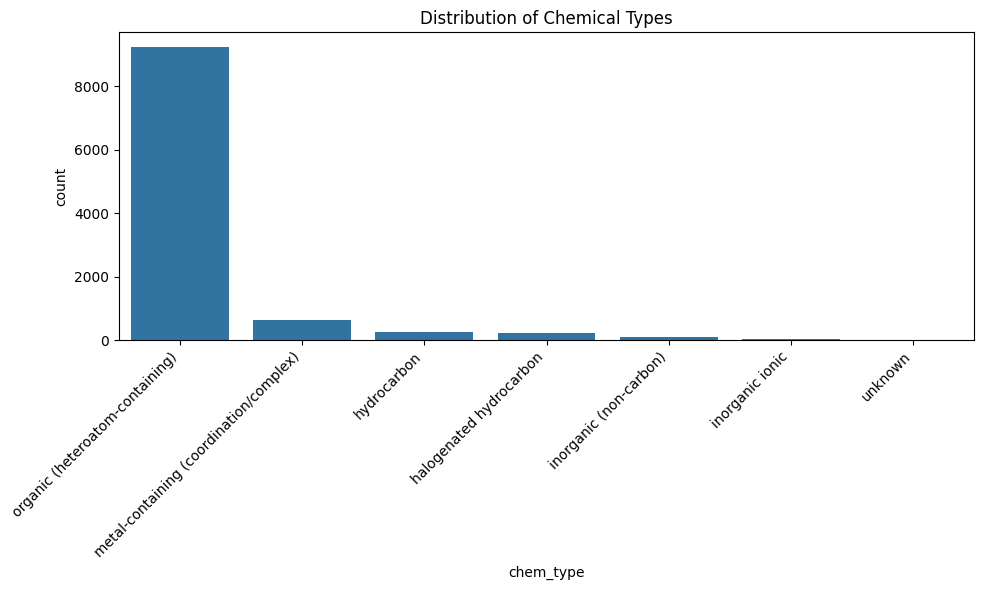

In [6]:
# plot distribution of chemical types
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='chem_type', order=df['chem_type'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Chemical Types')
plt.tight_layout()
plt.show()